In [13]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import subprocess
from pathlib import Path
import configparser
from scipy.stats import ranksums
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from statsmodels.stats import multitest as multi
import plotly.express as px
import plotly.graph_objects as go 
import shutil

#######################################################################################
#                              Carica il file di configurazione                       #
#######################################################################################

config = configparser.ConfigParser()
#script_dir = Path(__file__).parent

# Costruisci il percorso relativo al file di configurazione
config_file ='/Users/chiaranotturnogranieri/Desktop/progetti/git/web_app/webserver/webserver/conf.ini'

config.read(config_file) 
#directory base
output_data = config['Paths']['output_data']
base_dir = config.get('Paths', 'base_dir', fallback='')

# Costruisci i percorsi completi
def get_full_path(relative_path):
    return os.path.join(base_dir, relative_path)

# Accesso ai valori e costruzione dei percorsi
if 'miRNA' in config:
    miRNA_name = get_full_path(config['miRNA']['name'])
    miRNA_dataframe = get_full_path(config['miRNA']['dataframe'])

if 'gene' in config:
    gene_name_ENSG = get_full_path(config['gene']['name_ENSG'])
    gene_dataframe = get_full_path(config['gene']['dataframe'])
    gene_dataframe_FPKM = get_full_path(config['gene']['dataframe_FPKM'])

if 'protein' in config:
    protein_name = get_full_path(config['protein']['name'])
    protein_dataframe = get_full_path(config['protein']['dataframe'])

if 'clinical' in config:
    clinical_data= get_full_path(config['clinical']['dati_clinici'])
    dati_age= get_full_path(config['clinical']['dati_age'])
    clinical_OS= get_full_path(config['clinical']['clinical_OS'])

if 'os' in config:
    os_pathway=get_full_path(config['OS']['os_pathway'])
    


In [26]:

def open_dataframe_gene_overall(gene,tumor):
    df_ensg= pd.read_csv(gene_name_ENSG,sep='\t')
    result_index = df_ensg[(df_ensg['gene_id_version'] == gene) | (df_ensg['gene_id'] == gene) | (df_ensg['gene_symbol'] == gene)].index
    if not result_index.empty:
        gene_version=df_ensg.loc[result_index[0],'gene_id_version']
        indice=int(result_index[0])
        gene_dataframe_FPKM_tumor=os.path.join(gene_dataframe_FPKM,"Dataframe_FPKM_"+tumor+".csv")
        df=pd.read_csv(gene_dataframe_FPKM_tumor)
        df=df.set_index("gene_id")
        return(df)
    if gene in open(miRNA_name).read().split("\n"):
        df=pd.read_csv(miRNA_dataframe)
        df=df.set_index('miRNA_ID')
        return(df)
   
    if gene in open(protein_name).read().split("\n"):
        df=pd.read_csv(protein_dataframe)
        df=df.set_index('peptide_target')
        return (df)
    else: 
        print("per il nome inserito non è disponibile la ricerca")
        return 0



def dataframe_OStime(tumor):
    dfclinic=pd.read_csv(clinical_OS)    
    OS=(dfclinic[['bcr_patient_barcode','OS.time']]) 
    df1_mask=dfclinic['type']==tumor
    OS=dfclinic[df1_mask]
    OS=(OS[['bcr_patient_barcode','OS.time']]) 
    OS=OS.set_index('bcr_patient_barcode')
    #display(OS)
    OS=OS.dropna()
    return(OS)




def overall_survival_analysis(m,tumor,feature,cartella,df1,OS1,gene):
    
    
    i1=df1.loc[m,:] > df1.loc[m,:].median()
    i2 = df1.loc[m,:] < df1.loc[m,:].median() 
    
    kmf = KaplanMeierFitter()
    

    #if np.mean(list(df1.loc[m,i2]))>0:
    results = logrank_test((OS1[i1]), (OS1[i2]),list(df1.loc[m,i1]),list(df1.loc[m,i2]), alpha=.95)
    print(results.p_value )
    if results.p_value < 1:       
        print("p-value:",results.p_value)
        
        kmf.fit((OS1[i1]), list(df1.loc[m,i1]), label="Higher expression")
        a1 = kmf.plot()

        kmf.fit((OS1[i2]),list(df1.loc[m,i2]) , label="Lower expression")
        kmf.plot(ax=a1)
        plt.savefig(cartella+"/overallsurvival_"+gene+"_"+tumor+".png")
        
    else:
        print("ANALISI NON VALIDA pvalue>1")
        return(0)

0.5357827479910258
p-value: 0.5357827479910258


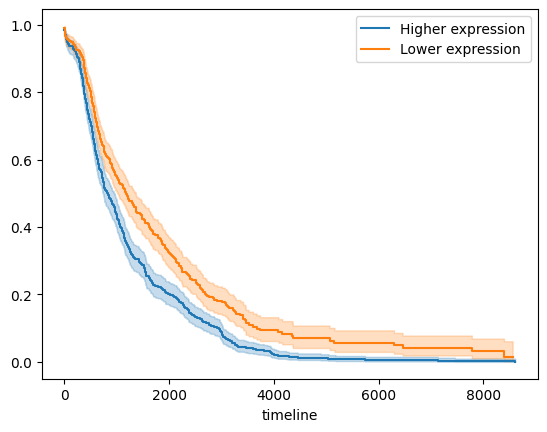

In [27]:
#!/usr/bin/env python
# coding: utf-8

# ANALISI OVERALL SURVIVAL
# 


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
#from function_new import open_dataframe_gene_overall,dataframe_OStime,overall_survival_analysis



if __name__ == "__main__":
    #dfclinic=read_clinical_data()
    #dfclinic=pd.read_csv('/mnt/data/notturno/TCGA-CDR-SupplementalTableS1.csv')
    # gene= sys.argv[1] #gene/mirna/protein
    # tumor=sys.argv[2]
    # cartella=sys.argv[3]
    feature='median'
    gene='ENSG00000012048.18'
    tumor= 'BRCA'
    cartella='/Users/chiaranotturnogranieri/Desktop/progetti/git/web_app/webserver/rolls/static/media/saveanalisi/prova'




    df=open_dataframe_gene_overall(gene,tumor)

    OS=dataframe_OStime(tumor)
    
    lista=list(OS.index)
    oslist=[]
    dflist=[]
    for name in df:
        if name[:-4] in lista:
            if name[-1]!="x" and name[-1]!="y":
                if int(name[-3:-1])<10:
                    oslist.append(name[:-4]) #lista dei campioni del tumore di cui abbiamo OS.time
                    dflist.append(name)

    df1=df[dflist]
    df1.columns= [(x[:-4]) for x in df1.columns]


    OS1=OS.loc[oslist,:]

    overall_survival_analysis(gene,tumor,feature, cartella,df1,OS1,gene)



